<a href="https://colab.research.google.com/github/BoKna031/Image_inpainting/blob/master/Image_inpainting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect to Kaggle dataset

In [1]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
#! kaggle datasets list

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d amanara/photos

Dataset URL: https://www.kaggle.com/datasets/amanara/photos
License(s): unknown
photos.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
!unzip photos.zip;

Archive:  photos.zip
replace Dataset/Testing_Data/Cat-Train (1).png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Data preparation

In [10]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt

TRAIN = 'Train'
TEST = 'Test'
img_size = (64, 64)

def load_training_dataset(category):
  TRAINING_DATA_FOLDER = os.path.join('Dataset', 'Training_Data', category)
  x_doc = os.path.join('Dataset', 'Training_Data', category, 'Masked_Train')
  x_imgs = _load_images_from_folder(x_doc, category, TRAIN)
  y_doc = os.path.join('Dataset', 'Training_Data', category, 'Unmasked_Train')
  y_imgs = _load_images_from_folder(y_doc, category, TRAIN)
  csv_file = pd.read_csv(os.path.join(TRAINING_DATA_FOLDER, 'masked_info.csv'))
  adjust_box_coordinate(csv_file)
  return x_imgs, y_imgs, csv_file

def adjust_box_coordinate(csv_df):
  ORG_IMG_SIZE = (256,256)
  scale_xy = img_size[0] / ORG_IMG_SIZE[0]
  csv_df[['box1_row', 'box1_col', 'box2_row', 'box2_col']] = (csv_df[['box1_row', 'box1_col', 'box2_row', 'box2_col']] * scale_xy).astype(int)


def _load_images_from_folder(folder, category, set_type):
    images = []
    for filename in os.listdir(folder):
            img = cv2.imread(os.path.join(folder, filename))
            img = cv2.resize(img, img_size)
            if img is not None:
              id, format = _parse_filename(filename)
              images.append({'filename': filename, 'category': category, 'id': id, 'set_type': set_type, 'format': format, 'image': img})
    images_df = pd.DataFrame(images, columns=['filename', 'category', 'id', 'set_type', 'format', 'image'])
    return images_df

import re

def _parse_filename(filename):
    regex_pattern = r'.*\((\d+)\)\.(\w+)$'

    match = re.match(regex_pattern, filename)

    if match:
        id = int(match.group(1))
        format =  match.group(2)
        return id, format
    else:
        return  None, None

def show_img(img, gray = False):
  if gray:
    plt.imshow(img, 'gray')
  else:
    plt.imshow(img)
  plt.axis('off')
  plt.show()


In [5]:
categories = ['Cat', 'Dog', 'Elephant', 'Tiger']

# Data analyzing

In [11]:
category = categories[0]
_, y, csv = load_training_dataset(category)
x_size = y['image'].apply(lambda img: pd.Series({'rows':img.shape[0], 'cols': img.shape[1]})).groupby(['rows','cols']).size()
print(f"{category}\n---------------------------")
print("total size = ",y.shape[0])
print(x_size)

Cat
---------------------------
total size =  1750
rows  cols
64    64      1750
dtype: int64


From the shown, it can be seen that all the images are of size 168x168

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
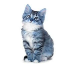

In [12]:
y.iloc[0]['image']

In [37]:
csv.head()

,Unnamed: 0,filename,box1_row,box1_col,box2_row,box2_col
0,0,Cat-Train (1085).jpeg,43,3,26,99
1,1,Cat-Train (900).jpeg,56,15,68,108
2,2,Cat-Train (1759).jpeg,39,64,1,91
3,3,Cat-Train (969).jpeg,9,90,30,89
4,4,Cat-Train (1559).jpeg,69,62,26,103


In [13]:
box_size = [15, 15]

def is_within_bounds(row, col):
  return row + box_size[0] <= img_size[0] and col + box_size[1] <= img_size[1]

In [14]:
csv['box1_within_bounds'] = csv.apply(lambda row: is_within_bounds(row['box1_row'], row['box1_col']), axis=1)
csv['box2_within_bounds'] = csv.apply(lambda row: is_within_bounds(row['box2_row'], row['box2_col']), axis=1)
invalid_boxes = csv[(~csv['box1_within_bounds']) | (~csv['box2_within_bounds'])]

In [15]:
csv.head()

,Unnamed: 0,filename,box1_row,box1_col,box2_row,box2_col,box1_within_bounds,box2_within_bounds
0,0,Cat-Train (1085).jpeg,16,1,10,38,True,True
1,1,Cat-Train (900).jpeg,21,5,26,41,True,True
2,2,Cat-Train (1759).jpeg,15,24,0,35,True,True
3,3,Cat-Train (969).jpeg,3,34,11,34,True,True
4,4,Cat-Train (1559).jpeg,26,23,10,39,True,True


In [16]:
print(f"There is {invalid_boxes.shape[0]} images that have invalid boxes")

There is 0 images that have invalid boxes


In [17]:
x_cp = y.copy(deep=True)

In [18]:
import numpy as np
def draw_masks(image, csv_row , box_size):
    col1, row1, col2, row2 = csv_row['box1_row'], csv_row['box1_col'], csv_row['box2_row'], csv_row['box2_col']
    mask = np.zeros(img_size)
    mask[row2:row2+box_size[0], col2:col2+box_size[1]] = 1
    #cv2.rectangle(mask, (row1, col1), (row1 + box_size[0], col1 + box_size[1]), (255, 255, 255), -1)
    #cv2.rectangle(mask, (row2, col2), (row2 + box_size[0], col2 + box_size[1]), (255, 255, 255), -1)
    #masked_image = cv2.bitwise_and(image, 255 - mask)
    img_cp = image.copy()
    img_cp[mask==1] = 0
    mask = mask[:, :, np.newaxis]
    rgbm_image = np.concatenate((img_cp, mask), axis=2).astype(np.int32)
    return rgbm_image

In [19]:
x_cp['image'] = x_cp.apply(lambda row: draw_masks(row['image'], csv[csv['filename'] == row['filename']].iloc[0], box_size), axis = 1)

In [20]:
type(x_cp.iloc[0]['image'])

numpy.ndarray

In [21]:
merged_data = pd.merge(x_cp, csv, on='filename')
merged_data = pd.merge(merged_data, y, on = 'filename')

In [22]:
final_table_columns = ['filename', 'image_x', 'image_y', 'box2_row', 'box2_col']
train_df = merged_data.drop(columns=[col for col in merged_data if col not in final_table_columns])

In [48]:
#train_df.head()

In [23]:
test_row = train_df.iloc[3]
x_coord, y_coord = test_row['box2_row'], test_row['box2_col']
print(x_coord, y_coord)

2 13


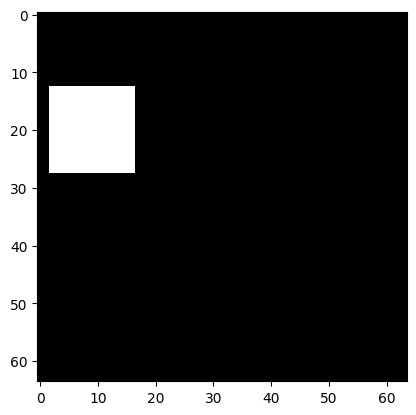

In [24]:
plt.imshow(test_row['image_x'][:,:,3], cmap='gray')
plt.show()

In [25]:
def crop_box(rgbm, y_img):
  mask = rgbm[:,:,3]
  rows, cols = np.where(mask == 1)

  min_row, max_row = np.min(rows), np.max(rows)
  min_col, max_col = np.min(cols), np.max(cols)

  return y_img[min_row:max_row + 1, min_col:max_col + 1, :]


In [26]:
train_df['image_y'] = train_df.apply(lambda row: crop_box(row['image_x'], row['image_y']), axis = 1)

In [27]:
train_df.iloc[1]['image_y']

array([[[197, 214, 216],
        [183, 192, 195],
        [131, 136, 135],
        [219, 219, 227],
        [200, 197, 227],
        [168, 170, 217],
        [160, 164, 216],
        [172, 177, 200],
        [109, 101,  93],
        [102,  73,  51],
        [104,  68,  45],
        [100,  67,  40],
        [ 95,  65,  37],
        [ 93,  62,  38],
        [ 91,  63,  39]],

       [[231, 247, 254],
        [208, 224, 231],
        [219, 232, 235],
        [218, 226, 246],
        [166, 170, 212],
        [169, 169, 227],
        [163, 167, 217],
        [154, 168, 202],
        [209, 211, 217],
        [ 90,  70,  51],
        [ 98,  68,  50],
        [ 95,  66,  47],
        [ 89,  64,  42],
        [ 87,  63,  40],
        [ 84,  60,  42]],

       [[224, 240, 247],
        [227, 243, 250],
        [227, 241, 248],
        [218, 229, 248],
        [170, 177, 214],
        [189, 193, 243],
        [174, 178, 229],
        [166, 173, 219],
        [210, 209, 234],
        [ 95,  80,  77],
        [ 93,  71,  58],
        [ 93,  70,  57],
        [ 90,  67,  51],
        [ 85,  63,  46],
        [ 85,  62,  46]],

       [[218, 234, 241],
        [219, 235, 242],
        [220, 236, 245],
        [209, 224, 241],
        [188, 201, 229],
        [184, 195, 232],
        [181, 186, 233],
        [164, 168, 222],
        [178, 178, 218],
        [126, 121, 133],
        [ 91,  81,  77],
        [ 92,  80,  75],
        [ 90,  74,  66],
        [ 88,  69,  60],
        [ 89,  67,  55]],

       [[202, 218, 225],
        [209, 225, 232],
        [208, 225, 235],
        [213, 229, 244],
        [204, 221, 243],
        [179, 196, 222],
        [179, 189, 225],
        [172, 175, 229],
        [149, 150, 197],
        [219, 223, 241],
        [140, 138, 139],
        [101,  95,  96],
        [ 93,  81,  79],
        [ 97,  80,  77],
        [ 91,  70,  63]],

       [[204, 214, 225],
        [213, 222, 234],
        [212, 228, 236],
        [208, 224, 236],
        [202, 218, 236],
        [198, 215, 237],
        [193, 207, 228],
        [189, 200, 232],
        [178, 189, 220],
        [202, 219, 234],
        [220, 234, 244],
        [184, 192, 200],
        [123, 124, 127],
        [103,  98,  98],
        [102,  87,  86]],

       [[198, 205, 219],
        [204, 211, 225],
        [203, 215, 226],
        [206, 220, 234],
        [206, 220, 238],
        [204, 219, 239],
        [211, 227, 241],
        [213, 226, 248],
        [206, 221, 240],
        [217, 235, 242],
        [215, 235, 242],
        [222, 239, 245],
        [211, 223, 226],
        [177, 185, 186],
        [145, 145, 150]],

       [[192, 196, 214],
        [194, 198, 216],
        [200, 208, 224],
        [205, 215, 231],
        [205, 218, 234],
        [205, 219, 236],
        [206, 220, 233],
        [206, 221, 233],
        [212, 228, 237],
        [218, 235, 241],
        [218, 242, 245],
        [222, 243, 246],
        [221, 240, 243],
        [210, 226, 229],
        [171, 183, 191]],

       [[178, 180, 198],
        [188, 190, 208],
        [190, 196, 214],
        [194, 201, 218],
        [195, 206, 223],
        [195, 208, 223],
        [194, 207, 223],
        [196, 210, 223],
        [204, 219, 228],
        [210, 225, 234],
        [212, 230, 232],
        [222, 240, 243],
        [234, 251, 255],
        [230, 246, 252],
        [231, 247, 252]],

       [[178, 178, 194],
        [179, 182, 197],
        [181, 190, 204],
        [182, 191, 205],
        [189, 198, 212],
        [194, 203, 217],
        [194, 203, 217],
        [200, 209, 223],
        [205, 215, 225],
        [208, 219, 227],
        [213, 224, 230],
        [217, 230, 236],
        [229, 245, 251],
        [226, 242, 248],
        [227, 239, 247]],

       [[169, 169, 185],
        [173, 176, 191],
        [174, 183, 197],
        [184, 193, 207],
        [191, 200, 214],
        [195, 204, 218],
        [197, 206, 220],
        [197, 206, 219],
        [199, 209, 218],
     

# Networks

In [28]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Activation, Reshape
from tensorflow.keras.models import Sequential

## CNN

In [29]:
euclidean_model_1 = Sequential()

euclidean_model_1.add(Conv2D(64, kernel_size=3, activation='relu', padding='same', input_shape=(img_size[0], img_size[1], 4)))
for i in range(9):
  if (i + 1) % 3 == 0:
     euclidean_model_1.add(Conv2D(64, kernel_size=3, padding='same', strides=2, activation='relu'))
  else:
    euclidean_model_1.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))

euclidean_model_1.add(Flatten())
euclidean_model_1.add(Dense(box_size[0]*box_size[1]*3, activation='relu'))
euclidean_model_1.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [30]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras import backend as K

def lr_schedule(epoch):
  model = euclidean_model_1 #change before model fit
  lr = K.get_value(model.optimizer.lr)
  if epoch % 5 == 0 and epoch > 0:
      K.set_value(model.optimizer.lr, lr * 0.8)
      print(f"Learning rate reduced to: {lr * 0.8}")
  return K.get_value(model.optimizer.lr)

batch_size = 64
weight_decay = 0.005
lr_scheduler = LearningRateScheduler(lr_schedule)

In [57]:
#train_df.iloc[0]['image_x']

In [31]:
print(type(train_df.iloc[0]['image_y']))
print(train_df.iloc[0]['image_y'].shape)

<class 'numpy.ndarray'>
(15, 15, 3)


In [59]:
#train_eucl_in =  np.asarray(train_df['image_x'])
#train_eucl_out = np.asarray(train_df['image_y'])
#train_eucl_out = np.reshape(train_eucl_out, (train_eucl_out.shape[0], 16875))

In [35]:
lr_scheduler = LearningRateScheduler(lr_schedule)
batch_size = 16
epochs = 5

In [33]:
X_train = np.stack(train_df['image_x'].values)
y_train = np.stack(train_df['image_y'].values)
y_train = y_train.reshape(y_train.shape[0],box_size[0]*box_size[1]*3)

In [36]:
history = euclidean_model_1.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[lr_scheduler],
    validation_split=0.2
)



Epoch 1/5
88/88 [==============================] - 102s 1s/step - loss: 1540.9509 - mae: 30.0851 - val_loss: 2067.2637 - val_mae: 34.4733 - lr: 4.0960e-04
Epoch 2/5
88/88 [==============================] - 98s 1s/step - loss: 1527.4351 - mae: 29.9992 - val_loss: 2134.9658 - val_mae: 34.8106 - lr: 4.0960e-04
Epoch 3/5
88/88 [==============================] - 100s 1s/step - loss: 1531.5887 - mae: 30.1554 - val_loss: 2113.0908 - val_mae: 34.7125 - lr: 4.0960e-04
Epoch 4/5
88/88 [==============================] - 98s 1s/step - loss: 1441.2357 - mae: 29.0661 - val_loss: 2181.4578 - val_mae: 35.6784 - lr: 4.0960e-04
Epoch 5/5
88/88 [==============================] - 96s 1s/step - loss: 1425.4265 - mae: 28.9070 - val_loss: 2146.2317 - val_mae: 35.2746 - lr: 4.0960e-04


In [37]:

import pickle

def save_history(history, path):
  with open(path, 'wb') as f:
    pickle.dump(history, f)

In [40]:
MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/ImageInpainting/CNN/trained-models"
HISTORY_PATH = "/content/drive/MyDrive/Colab Notebooks/ImageInpainting/CNN/history"

In [44]:
euclidean_model_1.save(MODEL_PATH + "/euclidean_model_1.keras")
save_history(history.history, HISTORY_PATH + "/euclidean_model_64_history.pkl")